# 2023 CITS4012 Assignment


# Readme

Run the cell chunk below to install the required packages.

In [1]:
%pip install optuna
%pip install numpy
%pip install pandas
%pip install sklearn
%pip install gensim
%pip install nltk
%pip install sklearn
%pip install tabulate
%pip install seaborn
%pip install matplotlib
%pip install torch
%pip install spacy
%python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [2]:
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec
import nltk
from nltk import word_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1.DataSet Processing


In [3]:
# reading in the data
train_data = pd.read_csv("WikiQA-train.tsv", sep="\t")
test_data = pd.read_csv("WikiQA-test.tsv", sep="\t")

Extract the unique questions from the train and test data frames, including the documentID and the DocumentTitle


In [4]:
def get_questions_documenttag(data):
    qd = data[
        ["Question", "QuestionID", "DocumentID", "DocumentTitle"]
    ].drop_duplicates()
    return qd


train_question_doctag = get_questions_documenttag(train_data)
test_question_doctag = get_questions_documenttag(test_data)

In [5]:
# get unique questions
train_questions = train_question_doctag["Question"]
test_questions = test_question_doctag["Question"]

In [6]:
# get the unique document ids
train_docid = train_question_doctag["DocumentID"]
test_docid = test_question_doctag["DocumentID"]

Extract the answers to those questions.


In [7]:
def get_answers(data, questions, documentids):
    answers = []  # list of answers
    for q in range(len(questions)):
        question = questions.iloc[q]
        doc_id = documentids.iloc[q]  # add the document id
        df = data[data["Question"] == question]
        index = df.loc[df["Label"] == 1]["Sentence"].index.values
        if len(index) == 0:  # if no answer found
            answers.append([question, doc_id, "No answer"])
        else:  # if 1 answer found
            answers.append([question, doc_id, df.loc[index[0], "Sentence"]])
    return answers


train_answers = pd.DataFrame(get_answers(train_data, train_questions, train_docid))
test_answers = pd.DataFrame(get_answers(test_data, test_questions, test_docid))

The above get_answers returns train_answers and test_answers which, gives us in the following columns

-   Question
-   Related Document ID
-   Answer (if no answer to that question, return no answer)


In [8]:
def get_documents(data, questions, documentids):  # (done by Finn, tweaked by Dan)
    documents = []
    for q in range(len(questions)):
        question = questions.iloc[q]
        doc_id = documentids.iloc[q]  # add the document id
        df = data[data["Question"] == question]
        sentences = df["Sentence"].tolist()
        for i in range(0, len(sentences) - 1):
            sentences[i] = sentences[i] + " "
        documents.append([doc_id, "".join(sentences)])
    return documents


train_documents = pd.DataFrame(
    get_documents(train_data, train_questions, train_docid)
)  # return the individual document in list
test_documents = pd.DataFrame(
    get_documents(test_data, test_questions, test_docid)
)  # return the individual document in list

The above train_documents and test_documents called from the get_documents gives us in the following columns

-   Document ID
-   Full Document


In [9]:
# renaming all the columns for more standardised access
train_answers.columns = ["Question", "DocumentID", "Answer"]
test_answers.columns = ["Question", "DocumentID", "Answer"]
train_documents.columns = ["DocumentID", "Document"]
test_documents.columns = ["DocumentID", "Document"]

In [10]:
# result is 2117, 2117, 630, 630

len(train_answers), len(train_documents), len(test_answers), len(test_documents)

(2117, 2117, 630, 630)

**Prior to tagging, we should maybe clean the document and answers first:** (stopped here)

Maybe?

-   lowercase (might lose context, but we can use on questions)
-   removing any punctuation or weird symbols (do)
-   removal of stop words? (probably not)

Make sure that the pre-processing is standardised to be the same throughout doc and ans.


In [11]:
# These are just common English contractions. We used it in Lab 5 before!
contraction_dict = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "this's": "this is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "here's": "here is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have",
}

In [12]:
def preprocess_lower(text):
    # Lowercase the text for question, answer and documents
    text = text.lower()
    for word, new_word in contraction_dict.items():
        text = text.replace(word, new_word)  # dealing with contractions
    pattern = r"[^a-zA-Z0-9\s]"
    cleaned_text = re.sub(pattern, " ", text)
    return cleaned_text


train_answers[["Question", "Answer"]] = train_answers[["Question", "Answer"]].applymap(
    preprocess_lower
)
train_documents["Document"] = train_documents["Document"].apply(preprocess_lower)
test_answers[["Question", "Answer"]] = test_answers[["Question", "Answer"]].applymap(
    preprocess_lower
)
test_documents["Document"] = test_documents["Document"].apply(preprocess_lower)

In [13]:
train_documents

,DocumentID,Document
0,D1,a partly submerged glacier cave on perito more...
1,D2,in physics circular motion is a movement of ...
2,D5,apollo creed is a fictional character from the...
3,D6,in the united states the title of federal jud...
4,D7,the beretta 21a bobcat is a small pocket sized...
...,...,...
2112,D2805,blue mountain state is an american comedy seri...
2113,D2806,apple inc formerly apple computer inc is ...
2114,D2807,section 8 housing in the south bronx section 8...
2115,D2808,restaurants categorized by type and informatio...


In [14]:
def labelling(documents, answers):
    tagged_documents = []
    for q in range(len(answers)):
        tagged_document = []
        qn = answers["Question"].loc[q]
        doc_id = answers["DocumentID"].loc[q]
        content = documents.loc[documents["DocumentID"] == doc_id, "Document"].values[0]
        answer = answers["Answer"].loc[q]

        if answer == "no answer":
            tokens = word_tokenize(content)
            for j in range(len(tokens)):
                tagged_document.append("N")  # none
        else:
            parts = content.partition(answer)
            for j in range(len(parts)):
                tokens = word_tokenize(parts[j])
                if j == 1:
                    tagged_document.append("S")  # start of answer
                    for k in range(len(tokens) - 2):
                        tagged_document.append("I")  # inside of answer
                    tagged_document.append("E")  # end of answer
                else:
                    for k in range(len(tokens)):
                        tagged_document.append("N")  # outside answer
        tagged_documents.append(tagged_document)
    return tagged_documents


train_doc_ans_labels = labelling(train_documents, train_answers)
test_doc_ans_labels = labelling(test_documents, test_answers)

In [15]:
# check if tags are good
def testing_tokens(ind, labels, documents, answers):
    for i, j in zip(labels[ind], word_tokenize(documents["Document"][ind])):
        print([i, j])
    print(answers["Answer"][ind])


testing_tokens(1000, train_doc_ans_labels, train_documents, train_answers)

['N', 'egg']
['N', 'roll']
['N', 'is']
['N', 'a']
['N', 'term']
['N', 'used']
['N', 'for']
['N', 'many']
['N', 'different']
['N', 'foods']
['N', 'around']
['N', 'the']
['N', 'world']
['S', '2']
['I', 'egg']
['I', 'roll']
['I', 'varieties']
['I', 'of']
['I', 'egg']
['I', 'rolls']
['I', 'are']
['I', 'found']
['I', 'in']
['I', 'mainland']
['I', 'china']
['I', 'many']
['I', 'chinese']
['I', 'speaking']
['I', 'regions']
['I', 'of']
['I', 'asia']
['I', 'and']
['I', 'chinese']
['I', 'immigrant']
['I', 'communities']
['I', 'around']
['I', 'the']
['E', 'world']
['N', 'egg']
['N', 'rolls']
['N', 'as']
['N', 'referred']
['N', 'to']
['N', 'in']
['N', 'china']
['N', 'in']
['N', 'guangdong']
['N', 'and']
['N', 'hong']
['N', 'kong']
['N', 'egg']
['N', 'roll']
['N', 'usually']
['N', 'refers']
['N', 'to']
['N', 'biscuit']
['N', 'roll']
['N', 'this']
['N', 'is']
['N', 'a']
['N', 'type']
['N', 'of']
['N', 'biscuit']
['N', 'the']
['N', 'ingredient']
['N', 'included']
['N', 'egg']
['N', 'flour']
['N', 'and

Cleaned Documents: train and test

train_answers - contains the ['Question','DocumentID','Answer']

train_documents - contains the ['DocumentID','Document']

train_doc_ans_labels - contains a list of list of answer tags for each document,


In [16]:
# To prepare the document for word embeddings:
train_doc_ques = pd.DataFrame(
    {"Document": train_documents["Document"], "Question": train_answers["Question"]}
)
test_doc_ques = pd.DataFrame(
    {"Document": test_documents["Document"], "Question": test_answers["Question"]}
)

# 2.QA Model Implementation


### Word Embeddings

To use the CBOW model, we need the data in sentences. Extract this from the original dataset, don't use sent_tokenise, will mess with some of the fullstops, we want to maintain structure from above


In [17]:
def word_tokens(data):
    sentence_list = []
    for i in range(len(data)):
        sentence_list.append(word_tokenize(data[i]))
    return sentence_list


train_doc_list = word_tokens(train_doc_ques["Document"])
train_ques_list = word_tokens(train_doc_ques["Question"])
test_doc_list = word_tokens(test_doc_ques["Document"])
test_ques_list = word_tokens(test_doc_ques["Question"])

In [18]:
combined_text = train_doc_list + train_ques_list + test_doc_list + test_ques_list

In [19]:
# model trained, don't have to run this multiple times
wc_cbow_model = Word2Vec(
    sentences=combined_text,
    vector_size=100,
    window=5,
    min_count=1,
    workers=2,
    epochs=30,
)
# wc_cbow_model.save("cbow.model")

To implement QA

1. Word Embeddings, using CBOW
2. Feature Extraction 1 - POS tags
3. Feature Extraction 2 - TF-IDF
4. Feature Extraction 3 - NER


In [20]:
# run this if model in directory
wc_cbow_model = Word2Vec.load("./cbow.model")

In [21]:
def get_word_embeddings(doc):
    tokenized_doc = word_tokenize(doc)
    embeddings = [wc_cbow_model.wv[word] for word in tokenized_doc]
    return embeddings


train_doc_ques["Doc_Embeddings"] = train_doc_ques["Document"].apply(get_word_embeddings)
train_doc_ques["Q_Embeddings"] = train_doc_ques["Question"].apply(get_word_embeddings)
test_doc_ques["Doc_Embeddings"] = test_doc_ques["Document"].apply(get_word_embeddings)
test_doc_ques["Q_Embeddings"] = test_doc_ques["Question"].apply(get_word_embeddings)

In [22]:
train_doc_ques["Doc_Tokens"] = train_doc_ques["Document"].apply(word_tokenize)
train_doc_ques["Q_Tokens"] = train_doc_ques["Question"].apply(word_tokenize)
test_doc_ques["Doc_Tokens"] = test_doc_ques["Document"].apply(word_tokenize)
test_doc_ques["Q_Tokens"] = test_doc_ques["Question"].apply(word_tokenize)

In [23]:
def find_max_length(column):
    max_length = 0
    lns = []
    for i in range(len(column)):
        lns.append(len(column[i]))
        if len(column[i]) > max_length:
            max_length = len(column[i])
    return "Max Seq Length is {}, Median is {}, Number of lines is {})".format(
        max_length, np.median(lns), len(lns)
    )


find_max_length(test_doc_ques["Doc_Embeddings"])
find_max_length(train_doc_ques["Doc_Embeddings"])

'Max Seq Length is 924, Median is 182.0, Number of lines is 2117)'

In [24]:
def check_count(doc):
    count = 0
    for i in range(len(doc)):
        if len(doc["Doc_Embeddings"][i]) != len(doc["Doc_Tokens"][i]):
            count += 1
        elif len(doc["Q_Embeddings"][i]) != len(doc["Q_Tokens"][i]):
            count += 1
        else:
            continue
    return count


check_count(train_doc_ques)  # looks good

0

Note, need to convert the POS tags, NER tags into embeddings. After this, pad the questions and answers to the max question/document length in the combined training and test set.

### PoS Tagging


In [25]:
# Apply the pos tags to the tokens
from nltk.tag import pos_tag

# download the dependency and resource as required
nltk.download("averaged_perceptron_tagger")

train_doc_ques["Doc_POS"] = train_doc_ques["Doc_Tokens"].apply(pos_tag)
train_doc_ques["Q_POS"] = train_doc_ques["Q_Tokens"].apply(pos_tag)
test_doc_ques["Doc_POS"] = test_doc_ques["Doc_Tokens"].apply(pos_tag)
test_doc_ques["Q_POS"] = test_doc_ques["Q_Tokens"].apply(pos_tag)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nicho\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [26]:
# checking the POS tags: # looks ok
train_doc_ques["Q_POS"][100]

[('how', 'WRB'),
 ('many', 'JJ'),
 ('schools', 'NNS'),
 ('are', 'VBP'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('big', 'JJ'),
 ('ten', 'NN')]

In [27]:
# Extract all unique POS Tags
all_pos_tags = (
    train_doc_ques["Doc_POS"].tolist()
    + test_doc_ques["Doc_POS"].tolist()
    + train_doc_ques["Q_POS"].tolist()
    + test_doc_ques["Q_POS"].tolist()
)


def get_unique_pos(data):
    pos_tags = set()
    for item in data:
        for _, pos_tag in item:
            pos_tags.add(pos_tag)

    pos_tag_index = {tag: i for i, tag in enumerate(sorted(pos_tags))}
    return pos_tag_index


pos_iden = get_unique_pos(all_pos_tags)  # list of tags
pos_iden

{'$': 0,
 'CC': 1,
 'CD': 2,
 'DT': 3,
 'EX': 4,
 'FW': 5,
 'IN': 6,
 'JJ': 7,
 'JJR': 8,
 'JJS': 9,
 'MD': 10,
 'NN': 11,
 'NNP': 12,
 'NNPS': 13,
 'NNS': 14,
 'PDT': 15,
 'POS': 16,
 'PRP': 17,
 'PRP$': 18,
 'RB': 19,
 'RBR': 20,
 'RBS': 21,
 'RP': 22,
 'SYM': 23,
 'TO': 24,
 'UH': 25,
 'VB': 26,
 'VBD': 27,
 'VBG': 28,
 'VBN': 29,
 'VBP': 30,
 'VBZ': 31,
 'WDT': 32,
 'WP': 33,
 'WP$': 34,
 'WRB': 35}

### NER Tagging


### Steps to run this:

-   pip install spacy
-   python -m spacy download en_core_web_sm

If loaded for the first time, restart kernel


In [28]:
# nltk using Spacy
# pip install -U spacy
# python -m spacy download en_core_web_sm
import spacy
import en_core_web_sm

# loading pre-trained model of NER
nlp = en_core_web_sm.load()
# nlp.to_disk("en_core_web_sm")

In [29]:
# nlp = spacy.load("./en_core_web_sm/")

In [30]:
def ner_tagging(texts):
    tagged_texts = []
    for text in texts:
        doc = spacy.tokens.Doc(nlp.vocab, words=text)
        nlp.get_pipe("ner")(doc)
        tagged_texts.append([(token.text, token.ent_type_) for token in doc])
    return tagged_texts

In [31]:
# Will take a while...
train_doc_ques["Doc_NER"] = ner_tagging(train_doc_ques["Doc_Tokens"])
train_doc_ques["Q_NER"] = ner_tagging(train_doc_ques["Q_Tokens"])
test_doc_ques["Doc_NER"] = ner_tagging(test_doc_ques["Doc_Tokens"])
test_doc_ques["Q_NER"] = ner_tagging(test_doc_ques["Q_Tokens"])

In [32]:
train_doc_ques["Q_NER"][12]

[('how', ''),
 ('much', ''),
 ('are', ''),
 ('the', ''),
 ('harry', 'WORK_OF_ART'),
 ('potter', 'WORK_OF_ART'),
 ('movies', 'WORK_OF_ART'),
 ('worth', 'WORK_OF_ART')]

In [33]:
# Similar approach to the POS

# Extract all unique POS Tags
all_ner_tags = (
    train_doc_ques["Doc_NER"].tolist()
    + test_doc_ques["Doc_NER"].tolist()
    + train_doc_ques["Q_NER"].tolist()
    + test_doc_ques["Q_NER"].tolist()
)


def get_unique_ner(data):
    ner_tags = set()
    for item in data:
        for _, ner_tag in item:
            ner_tags.add(ner_tag)

    ner_tag_index = {tag: i for i, tag in enumerate(sorted(ner_tags))}
    return ner_tag_index


ner_iden = get_unique_pos(all_ner_tags)  # list of tags
ner_iden

{'': 0,
 'CARDINAL': 1,
 'DATE': 2,
 'EVENT': 3,
 'FAC': 4,
 'GPE': 5,
 'LANGUAGE': 6,
 'LAW': 7,
 'LOC': 8,
 'MONEY': 9,
 'NORP': 10,
 'ORDINAL': 11,
 'ORG': 12,
 'PERCENT': 13,
 'PERSON': 14,
 'PRODUCT': 15,
 'QUANTITY': 16,
 'TIME': 17,
 'WORK_OF_ART': 18}

In [34]:
# check ohv dims
ner_idx = ner_iden.values()
aa = np.eye(max(ner_idx) + 1)
# aa

### TF-IDF

First, calculate the document frequency of each token in the entire corpus (training documents + testing documents). The result is a dictionary where each token is a key and its value is the document frequency.


In [35]:
def document_frequency(corpus):
    """
    Computes the document frequency for every token in the corpus.
    Returns a dictionary {token: doc_freq, ...}
    """
    document_frequency = {}
    for document in corpus:
        for token in np.unique(document):
            try:
                document_frequency[token] += 1
            except:
                document_frequency[token] = 1
    return document_frequency


train_corpus = (
    train_doc_ques["Doc_Tokens"].tolist() + train_doc_ques["Q_Tokens"].tolist()
)
test_corpus = test_doc_ques["Doc_Tokens"].tolist() + test_doc_ques["Q_Tokens"].tolist()
train_doc_freq = document_frequency(train_corpus)
test_doc_freq = document_frequency(test_corpus)

Now calculate TF-IDF using the document frequency from above.


In [36]:
from collections import Counter
import math


def compute_tf_idf(corpus, doc_frequency):
    """
    Computes the term frequency inverse document frequency for every token in every document in the corpus.
    Returns a list the same shape as the list of tokenized documents except every token is replaced with the tf-idf
    for that token.
    """
    tf_idf = {}
    tf_idf_list = []
    N = len(doc_frequency)
    doc_id = 0
    for document in corpus:
        tf_idf_doc = []
        counter = Counter(document)
        total_num_words = len(document)
        for token in np.unique(document):
            tf = counter[token] / total_num_words
            df = doc_frequency[token]
            idf = math.log(N / (df + 1)) + 1
            tf_idf[doc_id, token] = tf * idf
        for token in document:
            tf_idf_doc.append(tf_idf[doc_id, token])
        tf_idf_list.append(tf_idf_doc)
        doc_id += 1
    return tf_idf_list


train_doc_ques["Doc_TFIDF"] = compute_tf_idf(
    train_doc_ques["Doc_Tokens"].tolist(), train_doc_freq
)
train_doc_ques["Q_TFIDF"] = compute_tf_idf(
    train_doc_ques["Q_Tokens"].tolist(), train_doc_freq
)
test_doc_ques["Doc_TFIDF"] = compute_tf_idf(
    test_doc_ques["Doc_Tokens"].tolist(), test_doc_freq
)
test_doc_ques["Q_TFIDF"] = compute_tf_idf(
    test_doc_ques["Q_Tokens"].tolist(), test_doc_freq
)

In [37]:
def one_hot_vectorize(
    pos_tagger, ner_tagger, data
):  # pass in the unique dict for ner or pos
    pos_idx = pos_tagger.values()
    pos_ohv = np.eye(max(pos_idx) + 1)  # create the ohv
    ner_idx = ner_tagger.values()
    ner_ohv = np.eye(max(ner_idx) + 1)

    dpos_full_ohv, dner_full_ohv = [], []  # lists to append to
    qpos_full_ohv, qner_full_ohv = [], []  # lists to append to

    for item in data["Doc_POS"]:
        sent_ohv = []
        for word in item:
            tag = word[1]
            pos_index_iden = pos_tagger[tag]
            sent_ohv.append(pos_ohv[pos_index_iden])
        dpos_full_ohv.append(sent_ohv)

    for item in data["Q_POS"]:
        sent_ohv = []
        for word in item:
            tag = word[1]
            pos_index_iden = pos_tagger[tag]
            sent_ohv.append(pos_ohv[pos_index_iden])
        qpos_full_ohv.append(sent_ohv)

    for item in data["Doc_NER"]:
        sent_ohv = []
        for word in item:
            tag = word[1]
            ner_index_iden = ner_tagger[tag]
            sent_ohv.append(ner_ohv[ner_index_iden])
        dner_full_ohv.append(sent_ohv)

    for item in data["Q_NER"]:
        sent_ohv = []
        for word in item:
            tag = word[1]
            ner_index_iden = ner_tagger[tag]
            sent_ohv.append(ner_ohv[ner_index_iden])
        qner_full_ohv.append(sent_ohv)

    return (dpos_full_ohv, qpos_full_ohv, dner_full_ohv, qner_full_ohv)

In [38]:
# get the ohv for doc
(
    train_doc_pos_ohv,
    train_q_pos_ohv,
    train_doc_ner_ohv,
    train_q_ner_ohv,
) = one_hot_vectorize(pos_iden, ner_iden, train_doc_ques)
test_doc_pos_ohv, test_q_pos_ohv, test_doc_ner_ohv, test_q_ner_ohv = one_hot_vectorize(
    pos_iden, ner_iden, test_doc_ques
)

In [39]:
# reduce the dataframe to just tokens and embeddings:
doc_emb_train = train_doc_ques[["Doc_Tokens", "Doc_Embeddings", "Doc_TFIDF"]]
doc_pos_ner = pd.DataFrame({"Doc_POS": train_doc_pos_ohv, "Doc_NER": train_doc_ner_ohv})
doc_emb_train = pd.concat([doc_emb_train, doc_pos_ner], axis=1)

q_emb_train = train_doc_ques[["Q_Tokens", "Q_Embeddings", "Q_TFIDF"]]
q_pos_ner = pd.DataFrame({"Q_POS": train_q_pos_ohv, "Q_NER": train_q_ner_ohv})
q_emb_train = pd.concat([q_emb_train, q_pos_ner], axis=1)

In [40]:
doc_emb_test = test_doc_ques[["Doc_Tokens", "Doc_Embeddings", "Doc_TFIDF"]]
doc_pos_ner = pd.DataFrame({"Doc_POS": test_doc_pos_ohv, "Doc_NER": test_doc_ner_ohv})
doc_emb_test = pd.concat([doc_emb_test, doc_pos_ner], axis=1)

q_emb_test = test_doc_ques[["Q_Tokens", "Q_Embeddings", "Q_TFIDF"]]
q_pos_ner = pd.DataFrame({"Q_POS": test_q_pos_ohv, "Q_NER": test_q_ner_ohv})
q_emb_test = pd.concat([q_emb_test, q_pos_ner], axis=1)

### Word Embeddings (Doc and Qn)

The embeddings of the questions and answers of the train and test set can be found here:

-   Train Document - doc_emb_train
-   Train Q - q_emb_train
-   Test Document - doc_emb_test
-   Test Q - q_emb_test

The max_document size is 1675 and max_question size is 23.
Combine all the embeddings into a full array


In [41]:
def full_array(data, data_type="Document"):
    num_vec_length = 156
    max_doc = 1675
    max_qn = 23
    zero_vec = np.zeros(156)

    if data_type == "Document":
        full_vec = []  # create a list for list of list for document
        for dat in range(len(data)):  # go through each line
            doc_ques = data.loc[dat]  # document data
            v = []  # create list to each word
            for j in range(len(doc_ques.iloc[0])):
                vn = []  # list of concat word embeddings
                vn.append(doc_ques.iloc[1][j].tolist())  # Word2Vec
                vn.append(doc_ques.iloc[2][j])  # TF-IDF
                vn.append(doc_ques.iloc[3][j].tolist())  # POS
                vn.append(doc_ques.iloc[4][j].tolist())  # NER
                flatten = [
                    item
                    for sublist in vn
                    for item in (sublist if isinstance(sublist, list) else [sublist])
                ]
                v.append(flatten)
            while len(v) < max_doc:
                v.append(zero_vec)
            full_vec.append(v)

    if data_type == "Question":
        full_vec = []  # create a list for list of list for document
        for dat in range(len(data)):  # go through each line
            doc_ques = data.loc[dat]  # document data
            v = []  # create list to each word
            for j in range(len(doc_ques.iloc[0])):
                vn = []  # list of concat word embeddings
                vn.append(doc_ques.iloc[1][j].tolist())  # Word2Vec
                vn.append(doc_ques.iloc[2][j])  # TF-IDF
                vn.append(doc_ques.iloc[3][j].tolist())  # POS
                vn.append(doc_ques.iloc[4][j].tolist())  # NER
                flatten = [
                    item
                    for sublist in vn
                    for item in (sublist if isinstance(sublist, list) else [sublist])
                ]
                v.append(flatten)
            while len(v) < max_qn:
                v.append(zero_vec)
            full_vec.append(v)
    return full_vec

In [42]:
# Training/Test Documents to pass in, takes about a min
final_doc_train = np.stack(full_array(doc_emb_train, data_type="Document"))
final_doc_test = np.stack(full_array(doc_emb_test, data_type="Document"))

In [43]:
# Training/Test Questions to pass in, takes about a few seconds
final_qn_train = np.stack(full_array(q_emb_train, data_type="Question"))
final_qn_test = np.stack(full_array(q_emb_test, data_type="Question"))

In [44]:
def convert_labels(labels):
    check = []
    for i in labels:
        if len(i) < 1675:
            while len(i) < 1675:
                i.append("N")
            check.append(i)
        else:
            check.append(i)
    return check


tr_labels = np.array(convert_labels(train_doc_ans_labels))
ts_labels = np.array(convert_labels(test_doc_ans_labels))

Earlier, we found that the sequence length of the documents can get quite large, which might introduce a lot of noise into the model with paddings. One alternative to reduce this noise is to perhaps truncate the sequences down to just over the median for the documents. We also need to do this for the outputs.


In [45]:
find_max_length(test_doc_ques["Doc_Embeddings"]), find_max_length(
    train_doc_ques["Doc_Embeddings"]
), find_max_length(test_doc_ques["Q_Embeddings"]), find_max_length(
    train_doc_ques["Q_Embeddings"]
)

('Max Seq Length is 1675, Median is 181.0, Number of lines is 630)',
 'Max Seq Length is 924, Median is 182.0, Number of lines is 2117)',
 'Max Seq Length is 19, Median is 7.0, Number of lines is 630)',
 'Max Seq Length is 23, Median is 7.0, Number of lines is 2117)')

In [46]:
# truncate the embeddings and the labels to 200


def truncate(data, labels, max_seq=200):
    data = data[:, :max_seq, :]
    labels = labels[:, :max_seq]
    return data, labels


final_doc_train, tr_labels = truncate(final_doc_train, tr_labels)
final_doc_test, ts_labels = truncate(final_doc_test, ts_labels)

In [47]:
# final prepared documents are found here:

# final_doc_train, tr_labels - doc embeddings and output labels for training
# final_doc_test, ts_labels - doc embeddings and output labels for testing
# final_qn_train - question embeddings for training
# final_qn_test - question embeddings for testing

Convert the arrays to a float32, then save those np arrays


In [48]:
# reduce to float32
final_doc_train = final_doc_train.astype("float32")
final_doc_test = final_doc_test.astype("float32")
final_qn_train = final_qn_train.astype("float32")
final_qn_test = final_qn_test.astype("float32")

# save the np.arrays
np.save("./cleaneddata/final_doc_train.npy", final_doc_train)
np.save("./cleaneddata/final_doc_test.npy", final_doc_test)
np.save("./cleaneddata/final_qn_train.npy", final_qn_train)
np.save("./cleaneddata/final_qn_test.npy", final_qn_test)
np.save("./cleaneddata/tr_labels.npy", tr_labels)
np.save("./cleaneddata/ts_labels.npy", ts_labels)

## 2. Model Implementation


Running the data wrangling bit can be quite computationally intensive, so we aim to save the np arrays in our wd, then call it from there.


In [49]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# load in the np data from the cleaneddata folder
final_doc_test = np.load("cleaneddata/final_doc_test.npy")
final_doc_train = np.load("cleaneddata/final_doc_train.npy")
final_qn_train = np.load("cleaneddata/final_qn_train.npy")
final_qn_test = np.load("cleaneddata/final_qn_test.npy")
tr_labels = np.load("cleaneddata/tr_labels.npy")
ts_labels = np.load("cleaneddata/ts_labels.npy")

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
# check the shape of all the above
print(
    final_doc_test.shape,
    final_doc_train.shape,
    final_qn_train.shape,
    final_qn_test.shape,
    tr_labels.shape,
    ts_labels.shape,
)

(630, 200, 156) (2117, 200, 156) (2117, 23, 156) (630, 23, 156) (2117, 200) (630, 200)


In [52]:
# convert the numpy arrays to tensors
final_doc_test = torch.from_numpy(final_doc_test).to(device=device, dtype=torch.float32)
final_doc_train = torch.from_numpy(final_doc_train).to(
    device=device, dtype=torch.float32
)
final_qn_train = torch.from_numpy(final_qn_train).to(device=device, dtype=torch.float32)
final_qn_test = torch.from_numpy(final_qn_test).to(device=device, dtype=torch.float32)

In [53]:
# check the shapes of the tensors
print(
    final_doc_test.shape,
    final_doc_train.shape,
    final_qn_train.shape,
    final_qn_test.shape,
)

torch.Size([630, 200, 156]) torch.Size([2117, 200, 156]) torch.Size([2117, 23, 156]) torch.Size([630, 23, 156])


In the model input embedding Ablation study, we are given 3 variations of input embeddings to test. We will test 3 options:

1. Word2Vec only # 100 dims
2. Word2Vec + Tf-IDF # 101 dims
3. Word2Vec + all features (TF-IDF, POS, NER) # 156 dims

Since we are using tensors, we can use tensor slicing to take out the relevant features.
Our tensor of embeddings are built as follows (w2v, TF-IDF, POS, NER)


In [54]:
def convert_tensors(tf_doc_train, tf_doc_test, tf_qn_train, tf_qn_test, option=3):
    if option == 3:
        return tf_doc_train, tf_doc_test, tf_qn_train, tf_qn_test
    elif option == 1:
        tf_doc_train = tf_doc_train[:, :, :100]
        tf_doc_test = tf_doc_test[:, :, :100]
        tf_qn_train = tf_qn_train[:, :, :100]
        tf_qn_test = tf_qn_test[:, :, :100]
        return tf_doc_train, tf_doc_test, tf_qn_train, tf_qn_test
    elif option == 2:
        tf_doc_train = tf_doc_train[:, :, :101]
        tf_doc_test = tf_doc_test[:, :, :101]
        tf_qn_train = tf_qn_train[:, :, :101]
        tf_qn_test = tf_qn_test[:, :, :101]
        return tf_doc_train, tf_doc_test, tf_qn_train, tf_qn_test

In [55]:
# Create a mapping from label to index
label2index = {"N": 0, "S": 1, "I": 2, "E": 3}

# Find the maximum length of the label lists
max_len = final_doc_train.shape[1]

# Create a tensor to hold the one-hot encoded labels
train_labels = torch.zeros(
    len(tr_labels), max_len, len(label2index), device=device, dtype=torch.float32
)
test_labels = torch.zeros(
    len(ts_labels),
    max_len,
    len(label2index),
    device=device,
    dtype=torch.float32,
)

# Sets the first element of the third dimension of the target_labels tensor to 1
train_labels[:, :, 0] = 1
test_labels[:, :, 0] = 1

# Iterate over the label lists and one-hot encode the labels
for i, label_list in enumerate(tr_labels):
    for j, label in enumerate(label_list):
        index = label2index[label]
        # Sets all elements of the target_labels tensor at position (i,j) to 0
        train_labels[i, j] = 0
        train_labels[i, j, index] = 1

for i, label_list in enumerate(ts_labels):
    for j, label in enumerate(label_list):
        index = label2index[label]
        # Sets all elements of the target_labels tensor at position (i,j) to 0
        test_labels[i, j] = 0
        test_labels[i, j, index] = 1

In [56]:
from sklearn.utils.class_weight import compute_class_weight

# Reshape the target labels tensor
reshaped_target_labels = (
    train_labels.view(-1, 4).cpu().numpy()
)  # Assuming it's on the GPU

# Flatten the reshaped target labels
flattened_target_labels = reshaped_target_labels.argmax(axis=1)

# Calculate the class weights
class_weights = compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2, 3], y=flattened_target_labels
)

# Convert the class weights to a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

Data Preprocessing complete at this stage, we should check again the shapes of the tensors


### Model Architecture


In [57]:
from torch import Tensor
from enum import Enum
from typing import Literal

In [58]:
# Architecture of the model for the Document BiLSTM


class DocumentBiRNN(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers=1,
    ):
        super(DocumentBiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
        )

    def forward(self, input: Tensor):
        input = input.unsqueeze(1)
        output: Tensor
        output, _ = self.lstm(input)
        # print("document output shape: ", output.shape)
        return output


# Architecture of the model for the Question BiLSTM


class QuestionBiRNN(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers=1,
    ):
        super(QuestionBiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            bidirectional=True,
        )

    def forward(self, input: Tensor):
        input = input.unsqueeze(1)
        output, (hn, cn) = self.lstm(input)
        forward_hn = hn[-2, :, :]
        backward_hn = hn[-1, :, :]
        hidden = torch.cat((forward_hn, backward_hn), dim=-1).unsqueeze(0)
        # print("question hidden shape: ", hidden.shape)
        return hidden


# attention methods
class AttentionMethod(Enum):
    DOT_PRODUCT = "dot_product"
    SCALE_DOT_PRODUCT = "scale_dot_product"
    COSINE_SIMILARITY = "cosine_similarity"

    def __str__(self):
        return self.value


# Architecture of the model for the Attention Calculation


class Attention(nn.Module):
    def __init__(
        self,
        ques_len,
        hidden_size: int,
        attention_method: Literal[
            "dot_product",
            "scale_dot_product",
            "cosine_similarity",
        ] = "dot_product",
    ):
        super(Attention, self).__init__()
        self.out = nn.Linear(ques_len, hidden_size)
        self.hidden_size = hidden_size
        self.attention_method = AttentionMethod(attention_method)

    def forward(self, document_output, question_summary):
        if self.attention_method == AttentionMethod.DOT_PRODUCT:
            document_output = document_output.permute(
                1, 0, 2
            )  # torch.Size([200, 1, 16])
            question_summary = question_summary.permute(
                1, 2, 0
            )  # torch.Size([1, 16, 1])

            attention_scores = torch.bmm(document_output, question_summary).permute(
                1, 0, 2
            )
            # get attention weights
            attention_weights = nn.functional.softmax(attention_scores, dim=1)
            # attention_scores = torch.bmm(document_output, question_summary) / np.sqrt(self.hidden_size)
            # get context vector
            context_scores = torch.bmm(
                document_output.permute(1, 2, 0), attention_weights
            ).permute(0, 2, 1)
            return context_scores

        elif self.attention_method == AttentionMethod.SCALE_DOT_PRODUCT:
            document_output = document_output.permute(1, 0, 2)
            question_summary = question_summary.permute(1, 2, 0)
            attention_scores = torch.bmm(document_output, question_summary).permute(
                1, 0, 2
            ) / np.sqrt(self.hidden_size)
            attention_weights = nn.functional.softmax(attention_scores, dim=1)
            context_scores = torch.bmm(
                document_output.permute(1, 2, 0), attention_weights
            ).permute(0, 2, 1)
            return context_scores

        elif self.attention_method == AttentionMethod.COSINE_SIMILARITY:
            document_output = document_output.permute(1, 0, 2)
            question_summary = question_summary.permute(1, 2, 0)
            question_summary = question_summary.squeeze(-1)
            # cosine similarity attention:
            cos_sim = F.cosine_similarity(
                document_output, question_summary.unsqueeze(0), dim=-1
            ).T.unsqueeze(1)
            attention_weights = nn.functional.softmax(cos_sim, dim=1)
            context_scores = torch.bmm(
                document_output.permute(1, 2, 0), attention_weights
            ).permute(0, 2, 1)
            return context_scores


# Architecture of the model for the Attention Weighted Document Representation a.k.a ReadingComprehension
class ReadingComprehensionModel(nn.Module):
    def __init__(self, document_rnn, question_rnn, attention, hidden_size, output_size):
        super(ReadingComprehensionModel, self).__init__()
        self.document_rnn = document_rnn
        self.question_rnn = question_rnn
        self.attention = attention
        self.linear = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.linear2 = nn.Linear(hidden_size * 2, output_size)

    def predict_label(self, attention_output):
        attention_output = torch.squeeze(attention_output, 1)
        # pass to linear
        pred_weights = self.linear(attention_output)
        pred_weights = self.linear2(pred_weights)
        # get the softmax
        # pred_weights = nn.functional.softmax(pred_weights, dim=1)
        return pred_weights

In [59]:
# Function to train the model


def trainIter(
    model,
    document_inputs,
    question_inputs,
    target_labels,
    num_epochs,
    criterion,
    optimizer,
    verbose=True,
):
    model.train()

    for epoch in range(num_epochs):
        loss = 0
        for document_input, question_input, target_label in zip(
            document_inputs, question_inputs, target_labels
        ):
            # optimizer.zero_grad()

            document_output = model.document_rnn(document_input)
            question_summary = model.question_rnn(question_input)

            attention_output = model.attention(document_output, question_summary)

            token_label_logits = model.predict_label(attention_output).to(device)

            # print("token label logits shape: ", token_label_logits)
            # print("target label shape: ", target_label.shape)
            # print("token label logits: ", token_label_logits)

            # print(token_label_logits[0])
            # print(target_label[0])
            # raise TypeError("stop")

            loss += criterion(token_label_logits, target_label)
            optimizer.zero_grad()
            # print(loss)

        loss.backward()
        optimizer.step()

        avg_loss = loss.item() / len(document_inputs)

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [60]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

In [61]:
# Evalutation of the model

START_LABEL = 1
END_LABEL = 3


def evaluate(
    model,
    document_inputs,
    question_inputs,
    target_labels,
    criterion,
    output_dict=False,
    verbose=True,
):
    model.eval()
    with torch.no_grad():
        loss = 0
        all_predictions = []
        all_targets = []
        for document_input, question_input, target_label in zip(
            document_inputs, question_inputs, target_labels
        ):
            document_output = model.document_rnn(document_input)
            question_summary = model.question_rnn(question_input)
            attention_output = model.attention(document_output, question_summary)
            token_label_logits = model.predict_label(attention_output).to(device)
            loss += criterion(token_label_logits, target_label)

            # print(token_label_logits)

            predictions = token_label_logits.argmax(dim=-1).cpu().numpy()
            targets = target_label.argmax(dim=-1).cpu().numpy()
            # print(predictions == 1)

            if any(targets == START_LABEL) and any(targets == END_LABEL):
                # Find indices of start and end tokens
                start_token_idx = np.where(targets == START_LABEL)[0]
                end_token_idx = np.where(targets == END_LABEL)[0]

                # print("target: ", targets[start_token_idx[0] : end_token_idx[0] + 1])
                # print(
                #    "prediction: ",
                #    predictions[start_token_idx[0] : end_token_idx[0] + 1],
                # )
                # print()

                # Take slice of predictions and target_labels for sentence tokens
                sentence_prediction = predictions[
                    start_token_idx[0] : end_token_idx[0] + 1
                ]
                sentence_target = targets[start_token_idx[0] : end_token_idx[0] + 1]

                all_predictions.extend(sentence_prediction)
                all_targets.extend(sentence_target)
            else:
                # Use the whole document since there is no answer
                all_predictions.extend(predictions)
                all_targets.extend(targets)

        # print(all_predictions)
        # print(all_targets)

        avg_loss = loss.item() / len(document_inputs)
        cr = classification_report(
            all_targets, all_predictions, output_dict=output_dict
        )

        return cr

In [62]:
# prior to training
as_doc_train, as_doc_test, as_qn_train, as_qn_test = convert_tensors(
    final_doc_train, final_doc_test, final_qn_train, final_qn_test, 3
)
# if not running any ablation, use the free up space by deleting np arrays:
# del final_doc_test, final_doc_train, final_qn_train, final_qn_test, tr_labels, ts_labels

In [63]:
# Start of the training

from torch import optim


def train(
    as_doc_train=as_doc_train,
    as_qn_train=as_qn_train,
    train_labels=train_labels,
    hidden_size=64,
    epochs=10,
    learning_rate=0.01,
    num_layers=1,
    token_labels=4,
    attention_method: Literal[
        "dot_product",
        "scale_dot_product",
        "cosine_similarity",
    ] = "dot_product",
    verbose=True,
):
    # note the names of the tensors are changed to:
    # as_doc_train, as_doc_test, as_qn_train, as_qn_test, train_labels, test_labels are called before in the ablation part
    # to avoid confusion with the original tensors

    # as_doc_train, as_doc_test, as_qn_train, as_qn_test

    document_num_embeddings = as_doc_train.shape[2]
    question_num_embeddings = as_qn_train.shape[2]
    ques_len = as_qn_train.shape[1]

    document_rnn = DocumentBiRNN(
        hidden_size=hidden_size,
        input_size=document_num_embeddings,
        num_layers=num_layers,
    ).to(device)
    question_rnn = QuestionBiRNN(
        input_size=question_num_embeddings,
        hidden_size=hidden_size,
        num_layers=num_layers,
    ).to(device)
    attention = Attention(ques_len, hidden_size, attention_method).to(device)
    reading_comp = ReadingComprehensionModel(
        document_rnn,
        question_rnn,
        attention,
        hidden_size=hidden_size,
        output_size=token_labels,
    ).to(device)
    reading_comp_optimizer = optim.AdamW(reading_comp.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights

    trainIter(
        reading_comp,
        as_doc_train,
        as_qn_train,
        train_labels,
        epochs,
        criterion,
        reading_comp_optimizer,
        verbose=verbose,
    )

    return reading_comp, criterion

# 3.Model Testing


### 3.1. Input Embedding Ablation Study

The above model used the full context vector with all word embeddings taken (Word2Vec, POS, NER, TF-IDF). In this section, we want to study the results of:

1. Word2Vec Word embeddings only
2. Word2Vec + TF-IDF
3. Full vector, which we have ran the results above

As we have seen from the above study that the best attention was the dot product, we will standardise across the 3 experiments using this. Additionally, we use the same hyperparameters as above in the Attention Study.


In [64]:
# Word embeds only, important to run this as it also makes sure that the input size is correct
as_doc_train, as_doc_test, as_qn_train, as_qn_test = convert_tensors(
    final_doc_train, final_doc_test, final_qn_train, final_qn_test, 1
)
# check the tensor sizes
print(as_doc_train.shape, as_doc_test.shape, as_qn_train.shape, as_qn_test.shape)

torch.Size([2117, 200, 100]) torch.Size([630, 200, 100]) torch.Size([2117, 23, 100]) torch.Size([630, 23, 100])


**Word2Vec Word Embeddings Ablation Study**


In [65]:
import os


# Model evaluation for Word Embeds only
# testing with cosine similarity attention
model_path_word = "./pytorch/word_embeds_model.pt"

if os.path.exists(model_path_word):
    reading_comp_word = torch.load(model_path_word)
    criterion_word = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights
else:
    reading_comp_word, criterion_word = train(
        as_doc_train=as_doc_train,
        as_qn_train=as_qn_train,
        train_labels=train_labels,
        attention_method="dot_product",
    )
    torch.save(reading_comp_word, model_path_word)

word_train_report, word_test_report = evaluate(
    reading_comp_word, as_doc_train, as_qn_train, train_labels, criterion_word
), evaluate(reading_comp_word, as_doc_test, as_qn_test, test_labels, criterion_word)

Epoch 1/10, Loss: 1.3867
Epoch 2/10, Loss: 1.2775
Epoch 3/10, Loss: 1.1275
Epoch 4/10, Loss: 0.9859
Epoch 5/10, Loss: 0.9113
Epoch 6/10, Loss: 0.9117
Epoch 7/10, Loss: 0.8561
Epoch 8/10, Loss: 0.7768
Epoch 9/10, Loss: 0.7587
Epoch 10/10, Loss: 0.7003


In [66]:
# Model evaluation for train and test set
print("Evaluation on train set")
print(word_train_report)
print("----------------------------------------------------------")
print("Evaluation on test set")
print(word_test_report)
print("----------------------------------------------------------")

Evaluation on train set
              precision    recall  f1-score   support

           0       0.97      0.62      0.76    260691
           1       0.05      0.79      0.09       826
           2       0.16      0.56      0.24     19947
           3       0.02      0.90      0.05       812

    accuracy                           0.62    282276
   macro avg       0.30      0.72      0.29    282276
weighted avg       0.90      0.62      0.72    282276

----------------------------------------------------------
Evaluation on test set
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     80177
           1       0.04      0.73      0.08       230
           2       0.12      0.53      0.20      5295
           3       0.02      0.78      0.04       229

    accuracy                           0.59     85931
   macro avg       0.29      0.66      0.26     85931
weighted avg       0.91      0.59      0.70     85931

------------------------

**Word2Vec + TF-IDF**


In [67]:
# Word embeds + TF-IDF, important to run this as it also makes sure that the input size is correct
as_doc_train, as_doc_test, as_qn_train, as_qn_test = convert_tensors(
    final_doc_train, final_doc_test, final_qn_train, final_qn_test, 2
)
# check the tensor sizes
print(as_doc_train.shape, as_doc_test.shape, as_qn_train.shape, as_qn_test.shape)

torch.Size([2117, 200, 101]) torch.Size([630, 200, 101]) torch.Size([2117, 23, 101]) torch.Size([630, 23, 101])


In [68]:
# testing with cosine similarity attention
model_path_tfidf = "./pytorch/word_embeds_tfidf_model.pt"

if os.path.exists(model_path_tfidf):
    reading_comp_tfidf = torch.load(model_path_tfidf)
    criterion_tfidf = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights
else:
    reading_comp_tfidf, criterion_tfidf = train(
        as_doc_train=as_doc_train,
        as_qn_train=as_qn_train,
        train_labels=train_labels,
        attention_method="dot_product",
    )
    torch.save(reading_comp_tfidf, model_path_tfidf)

tfidf_train_report, tfidf_test_report = evaluate(
    reading_comp_tfidf, as_doc_train, as_qn_train, train_labels, criterion_tfidf
), evaluate(reading_comp_tfidf, as_doc_test, as_qn_test, test_labels, criterion_tfidf)

Epoch 1/10, Loss: 1.3906
Epoch 2/10, Loss: 1.3049
Epoch 3/10, Loss: 1.1785
Epoch 4/10, Loss: 1.0271
Epoch 5/10, Loss: 0.9114
Epoch 6/10, Loss: 0.8713
Epoch 7/10, Loss: 0.7904
Epoch 8/10, Loss: 0.7573
Epoch 9/10, Loss: 0.6894
Epoch 10/10, Loss: 0.6684


In [69]:
# Model evaluation for train and test set
print("Evaluation on train set")
print(tfidf_train_report)
print("----------------------------------------------------------")
print("Evaluation on test set")
print(tfidf_test_report)
print("----------------------------------------------------------")

Evaluation on train set
              precision    recall  f1-score   support

           0       0.98      0.50      0.67    260691
           1       0.02      0.94      0.04       826
           2       0.15      0.60      0.24     19947
           3       0.03      0.92      0.05       812

    accuracy                           0.51    282276
   macro avg       0.29      0.74      0.25    282276
weighted avg       0.91      0.51      0.63    282276

----------------------------------------------------------
Evaluation on test set
              precision    recall  f1-score   support

           0       0.98      0.48      0.64     80177
           1       0.02      0.88      0.03       230
           2       0.12      0.58      0.20      5295
           3       0.02      0.82      0.04       229

    accuracy                           0.49     85931
   macro avg       0.28      0.69      0.23     85931
weighted avg       0.92      0.49      0.61     85931

------------------------

**Input Embeddings Ablation Study Table**


In [70]:
from tabulate import tabulate

tfidf_train_report, tfidf_test_report = evaluate(
    reading_comp_tfidf,
    as_doc_train,
    as_qn_train,
    train_labels,
    criterion_tfidf,
    output_dict=True,
    verbose=False,
), evaluate(
    reading_comp_tfidf,
    as_doc_test,
    as_qn_test,
    test_labels,
    criterion_tfidf,
    output_dict=True,
    verbose=False,
)

as_doc_train, as_doc_test, as_qn_train, as_qn_test = convert_tensors(
    final_doc_train, final_doc_test, final_qn_train, final_qn_test, 1
)

word_train_report, word_test_report = evaluate(
    reading_comp_word,
    as_doc_train,
    as_qn_train,
    train_labels,
    criterion_word,
    output_dict=True,
    verbose=False,
), evaluate(
    reading_comp_word,
    as_doc_test,
    as_qn_test,
    test_labels,
    criterion_word,
    output_dict=True,
    verbose=False,
)

as_doc_train, as_doc_test, as_qn_train, as_qn_test = convert_tensors(
    final_doc_train, final_doc_test, final_qn_train, final_qn_test, 3
)

model_path_dot = "./pytorch/dot_product_model.pt"

if os.path.exists(model_path_dot):
    reading_comp_dot = torch.load(model_path_dot)
    criterion_dot = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights
else:
    reading_comp_dot, criterion_dot = train(attention_method="dot_product")
    torch.save(reading_comp_dot, model_path_dot)

# Model evaluation
train_report, test_report = evaluate(
    reading_comp_dot, as_doc_train, as_qn_train, train_labels, criterion_dot
), evaluate(reading_comp_dot, as_doc_test, as_qn_test, test_labels, criterion_dot)

# Model evaluation
train_report, test_report = evaluate(
    reading_comp_dot,
    as_doc_train,
    as_qn_train,
    train_labels,
    criterion_dot,
    output_dict=True,
    verbose=False,
), evaluate(
    reading_comp_dot,
    as_doc_test,
    as_qn_test,
    test_labels,
    criterion_dot,
    output_dict=True,
    verbose=False,
)


# Assuming you have already trained and evaluated models for all 3 attention methods
# and have obtained the classification reports for each method
reports = {
    "Word2Vec": {
        "train": word_train_report,
        "test": word_test_report,
    },
    "Word2Vec, TF-IDF": {
        "train": tfidf_train_report,
        "test": tfidf_test_report,
    },
    "Word2Vec, POS, NER, TF-IDF": {"train": train_report, "test": test_report},
}

# Create tables for train and test data
for data_type in ["train", "test"]:
    table = []
    headers = ["Input Embeddings", "Precision", "Recall", "F1-score"]
    for method, report in reports.items():
        precision = report[data_type]["macro avg"]["precision"]
        recall = report[data_type]["macro avg"]["recall"]
        f1_score = report[data_type]["macro avg"]["f1-score"]
        table.append([method, precision, recall, f1_score])
    print(f"{data_type.capitalize()} Data:")
    print(tabulate(table, headers=headers))
    print("----------------------------------------------------------")

Epoch 1/10, Loss: 1.3890
Epoch 2/10, Loss: 1.2923
Epoch 3/10, Loss: 1.1453
Epoch 4/10, Loss: 0.9816
Epoch 5/10, Loss: 0.8756
Epoch 6/10, Loss: 0.8677
Epoch 7/10, Loss: 0.8700
Epoch 8/10, Loss: 0.8677
Epoch 9/10, Loss: 0.7803
Epoch 10/10, Loss: 0.6987
Train Data:
Input Embeddings              Precision    Recall    F1-score
--------------------------  -----------  --------  ----------
Word2Vec                       0.298786  0.718127    0.285491
Word2Vec, TF-IDF               0.293073  0.740146    0.248373
Word2Vec, POS, NER, TF-IDF     0.296887  0.696257    0.283438
----------------------------------------------------------
Test Data:
Input Embeddings              Precision    Recall    F1-score
--------------------------  -----------  --------  ----------
Word2Vec                       0.28647   0.658806    0.26203
Word2Vec, TF-IDF               0.283603  0.69001     0.22864
Word2Vec, POS, NER, TF-IDF     0.286712  0.64179     0.265363
-------------------------------------------------

### 3.2. Attention Ablation Study

In this section, we study 3 different type of attention mechanisms between the question model and the document model. We ensured that the 3 attention mechanisms are ran on the same model hyperparameters, so as to keep things interpretable and standardized across the study.

The hyperparameters of the training model are as follows:

-   RNN (Bi-LSTM) Hidden Size: 64,
-   Number of epochs: 10,
-   Learning Rate: 0.01,
-   Number of RNN (Bi-LSTM) layers: 1

**Attention Ablation Study - Dot Product**


In [71]:
model_path_dot = "./pytorch/dot_product_model.pt"

if os.path.exists(model_path_dot):
    reading_comp_dot = torch.load(model_path_dot)
    criterion_dot = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights
else:
    reading_comp_dot, criterion_dot = train(attention_method="dot_product")
    torch.save(reading_comp_dot, model_path_dot)

# Model evaluation
train_report, test_report = evaluate(
    reading_comp_dot, as_doc_train, as_qn_train, train_labels, criterion_dot
), evaluate(reading_comp_dot, as_doc_test, as_qn_test, test_labels, criterion_dot)

In [72]:
# Model evaluation for train and test set
print("Evaluation on train set")
print(train_report)
print("----------------------------------------------------------")
print("Evaluation on test set")
print(test_report)
print("----------------------------------------------------------")

Evaluation on train set
              precision    recall  f1-score   support

           0       0.96      0.65      0.78    260691
           1       0.02      0.93      0.04       826
           2       0.17      0.42      0.24     19947
           3       0.04      0.78      0.08       812

    accuracy                           0.64    282276
   macro avg       0.30      0.70      0.28    282276
weighted avg       0.90      0.64      0.73    282276

----------------------------------------------------------
Evaluation on test set
              precision    recall  f1-score   support

           0       0.96      0.63      0.76     80177
           1       0.02      0.89      0.03       230
           2       0.14      0.43      0.21      5295
           3       0.03      0.62      0.06       229

    accuracy                           0.62     85931
   macro avg       0.29      0.64      0.27     85931
weighted avg       0.91      0.62      0.72     85931

------------------------

**Attention Ablation Study - Scaled Dot Product**


In [73]:
# testing with scaled dot product attention
model_path_scaled = "./pytorch/scale_dot_product_model.pt"

if os.path.exists(model_path_scaled):
    reading_comp_scaled = torch.load(model_path_scaled)
    criterion_scaled = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights
else:
    reading_comp_scaled, criterion_scaled = train(attention_method="scale_dot_product")
    torch.save(reading_comp_scaled, model_path_scaled)

Epoch 1/10, Loss: 1.3865
Epoch 2/10, Loss: 1.2971
Epoch 3/10, Loss: 1.1555
Epoch 4/10, Loss: 1.0025
Epoch 5/10, Loss: 0.8888
Epoch 6/10, Loss: 0.9968
Epoch 7/10, Loss: 0.8217
Epoch 8/10, Loss: 0.8119
Epoch 9/10, Loss: 0.7092
Epoch 10/10, Loss: 0.6854


In [74]:
scaled_train_report, scaled_test_report = evaluate(
    reading_comp_scaled, as_doc_train, as_qn_train, train_labels, criterion_scaled
), evaluate(reading_comp_scaled, as_doc_test, as_qn_test, test_labels, criterion_scaled)

# model evaluation for train and test set
print("Evaluation on train set")
print(scaled_train_report)
print("----------------------------------------------------------")
print("Evaluation on test set")
print(scaled_test_report)
print("----------------------------------------------------------")

Evaluation on train set
              precision    recall  f1-score   support

           0       0.96      0.61      0.75    260691
           1       0.02      0.94      0.03       826
           2       0.17      0.31      0.22     19947
           3       0.02      0.92      0.04       812

    accuracy                           0.59    282276
   macro avg       0.29      0.70      0.26    282276
weighted avg       0.90      0.59      0.71    282276

----------------------------------------------------------
Evaluation on test set
              precision    recall  f1-score   support

           0       0.96      0.59      0.73     80177
           1       0.01      0.88      0.03       230
           2       0.14      0.32      0.20      5295
           3       0.02      0.83      0.04       229

    accuracy                           0.58     85931
   macro avg       0.28      0.66      0.25     85931
weighted avg       0.91      0.58      0.70     85931

------------------------

**Attention Ablation Study - Cosine Similarity**


In [75]:
# testing with cosine similarity attention
model_path_cosine = "./pytorch/cosine_similarity_model.pt"

if os.path.exists(model_path_cosine):
    reading_comp_cosine = torch.load(model_path_cosine)
    criterion_cosine = nn.CrossEntropyLoss(
        weight=class_weights
    )  # to account for imbalanced class weights
else:
    reading_comp_cosine, criterion_cosine = train(attention_method="cosine_similarity")
    torch.save(reading_comp_cosine, model_path_cosine)

Epoch 1/10, Loss: 1.3864
Epoch 2/10, Loss: 1.2873
Epoch 3/10, Loss: 1.1384
Epoch 4/10, Loss: 0.9905
Epoch 5/10, Loss: 0.8802
Epoch 6/10, Loss: 0.8648
Epoch 7/10, Loss: 0.7863
Epoch 8/10, Loss: 0.6982
Epoch 9/10, Loss: 0.6671
Epoch 10/10, Loss: 0.6410


In [76]:
# model evaluation for train and test set
cosine_train_report, cosine_test_report = evaluate(
    reading_comp_cosine, as_doc_train, as_qn_train, train_labels, criterion_cosine
), evaluate(reading_comp_cosine, as_doc_test, as_qn_test, test_labels, criterion_cosine)

print("Evaluation on train set")
print(cosine_train_report)
print("----------------------------------------------------------")
print("Evaluation on test set")
print(cosine_test_report)
print("----------------------------------------------------------")

Evaluation on train set
              precision    recall  f1-score   support

           0       0.98      0.44      0.60    260691
           1       0.03      0.90      0.06       826
           2       0.13      0.75      0.22     19947
           3       0.03      0.94      0.05       812

    accuracy                           0.46    282276
   macro avg       0.29      0.76      0.23    282276
weighted avg       0.92      0.46      0.57    282276

----------------------------------------------------------
Evaluation on test set
              precision    recall  f1-score   support

           0       0.98      0.41      0.58     80177
           1       0.03      0.83      0.05       230
           2       0.11      0.73      0.19      5295
           3       0.02      0.81      0.04       229

    accuracy                           0.43     85931
   macro avg       0.28      0.70      0.21     85931
weighted avg       0.92      0.43      0.55     85931

------------------------

**Attention Methods Table**


In [77]:
from tabulate import tabulate

# Model evaluation
train_report, test_report = evaluate(
    reading_comp_dot,
    as_doc_train,
    as_qn_train,
    train_labels,
    criterion_dot,
    output_dict=True,
    verbose=False,
), evaluate(
    reading_comp_dot,
    as_doc_test,
    as_qn_test,
    test_labels,
    criterion_dot,
    output_dict=True,
    verbose=False,
)

scaled_train_report, scaled_test_report = evaluate(
    reading_comp_scaled,
    as_doc_train,
    as_qn_train,
    train_labels,
    criterion_scaled,
    output_dict=True,
    verbose=False,
), evaluate(
    reading_comp_scaled,
    as_doc_test,
    as_qn_test,
    test_labels,
    criterion_scaled,
    output_dict=True,
    verbose=False,
)

cosine_train_report, cosine_test_report = evaluate(
    reading_comp_cosine,
    as_doc_train,
    as_qn_train,
    train_labels,
    criterion_cosine,
    output_dict=True,
    verbose=False,
), evaluate(
    reading_comp_cosine,
    as_doc_test,
    as_qn_test,
    test_labels,
    criterion_cosine,
    output_dict=True,
    verbose=False,
)

# Assuming you have already trained and evaluated models for all 3 attention methods
# and have obtained the classification reports for each method
reports = {
    "dot_product": {"train": train_report, "test": test_report},
    "scaled_dot_product": {
        "train": scaled_train_report,
        "test": scaled_test_report,
    },
    "cosine_similarity": {
        "train": cosine_train_report,
        "test": cosine_test_report,
    },
}

# Create tables for train and test data
for data_type in ["train", "test"]:
    table = []
    headers = ["Attention Method", "Precision", "Recall", "F1-score"]
    for method, report in reports.items():
        precision = report[data_type]["macro avg"]["precision"]
        recall = report[data_type]["macro avg"]["recall"]
        f1_score = report[data_type]["macro avg"]["f1-score"]
        table.append([method, precision, recall, f1_score])
    print(f"{data_type.capitalize()} Data:")
    print(tabulate(table, headers=headers))
    print("----------------------------------------------------------")

Train Data:
Attention Method      Precision    Recall    F1-score
------------------  -----------  --------  ----------
dot_product            0.296887  0.696257    0.283438
scaled_dot_product     0.291645  0.697052    0.260815
cosine_similarity      0.293333  0.756794    0.234538
----------------------------------------------------------
Test Data:
Attention Method      Precision    Recall    F1-score
------------------  -----------  --------  ----------
dot_product            0.286712  0.64179     0.265363
scaled_dot_product     0.284361  0.656643    0.248667
cosine_similarity      0.284183  0.696059    0.213461
----------------------------------------------------------


### 3.3. Hyper Parameter Testing


In this section, we will fine tune the hyperparameter of the model to see if we can get better results. We will be testing the following hyperparameter: learning rate [0.00001, 0.0001, 0.001, 0.01, 0.1].


In [78]:
import optuna

In [79]:
from sklearn.model_selection import KFold
import json


mean_cv_precision_scores = {}
mean_cv_recall_scores = {}
mean_cv_f1_scores = {}


def objective(trial):
    # Define the hyperparameters to search over
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    # Create a KFold object for cross-validation
    kf = KFold(n_splits=3)

    # Initialize a list to store the cross-validation scores
    cv_precision_scores = []
    cv_recall_scores = []
    cv_f1_scores = []

    # Perform cross-validation
    for train_index, val_index in kf.split(as_doc_train):
        # Split the data into training and validation sets
        doc_train, doc_val = as_doc_train[train_index], as_doc_train[val_index]
        que_train, que_val = as_qn_train[train_index], as_qn_train[val_index]
        label_train, label_val = train_labels[train_index], train_labels[val_index]

        # Train the model on the training set
        reading_comp_dot, criterion_dot = train(
            doc_train,
            que_train,
            label_train,
            attention_method="dot_product",
            learning_rate=learning_rate,
            verbose=False,
        )

        # Evaluate the model on the validation set
        val_report = evaluate(
            reading_comp_dot,
            doc_val,
            que_val,
            label_val,
            criterion_dot,
            output_dict=True,
            verbose=False,
        )
        # Store the validation score
        cv_precision_scores.append(val_report["macro avg"]["precision"])
        cv_recall_scores.append(val_report["macro avg"]["recall"])
        cv_f1_scores.append(val_report["macro avg"]["f1-score"])
    print(f"Learning rate: {learning_rate:.4f}, F1: {np.mean(cv_f1_scores):.4f}")

    mean_cv_precision_scores[learning_rate] = np.mean(cv_precision_scores)
    mean_cv_recall_scores[learning_rate] = np.mean(cv_recall_scores)
    mean_cv_f1_scores[learning_rate] = np.mean(cv_f1_scores)

    # Return the average cross-validation score
    return np.mean(cv_f1_scores)


# Create a study object and optimize the objective function
study_name = "reading_comprehension"  # Unique identifier of the study.
storage_name = f"sqlite:///./optuna/{study_name}.db"
sampler = optuna.samplers.GridSampler({"learning_rate": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]})
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction="maximize",
    sampler=sampler,
)
# Check if the study is new
if len(study.trials) == 0:
    # Optimize only for new study
    study.optimize(objective, n_trials=5, n_jobs=1, show_progress_bar=True)
    # Save the dictionary to a JSON file
    with open("./optuna/precision.json", "w") as f:
        json.dump(mean_cv_precision_scores, f)
    with open("./optuna/recall.json", "w") as f:
        json.dump(mean_cv_recall_scores, f)
    with open("./optuna/f1.json", "w") as f:
        json.dump(mean_cv_f1_scores, f)
else:
    print(f"Study {study_name} already exists in storage. Skipping optimization.")
    with open("./optuna/precision.json", "r") as f:
        mean_cv_precision_scores = json.load(f)
    with open("./optuna/recall.json", "r") as f:
        mean_cv_recall_scores = json.load(f)
    with open("./optuna/f1.json", "r") as f:
        mean_cv_f1_scores = json.load(f)
    # Create new dictionaries with the keys converted to integers
    new_mean_cv_precision_scores = {}
    new_mean_cv_recall_scores = {}
    new_mean_cv_f1_scores = {}

    for key, value in mean_cv_precision_scores.items():
        new_mean_cv_precision_scores[float(key)] = value
    for key, value in mean_cv_recall_scores.items():
        new_mean_cv_recall_scores[float(key)] = value
    for key, value in mean_cv_f1_scores.items():
        new_mean_cv_f1_scores[float(key)] = value

    # Update the original dictionaries with the new dictionaries
    mean_cv_precision_scores = new_mean_cv_precision_scores
    mean_cv_recall_scores = new_mean_cv_recall_scores
    mean_cv_f1_scores = new_mean_cv_f1_scores

[I 2023-05-20 17:24:59,935] A new study created in RDB with name: reading_comprehension
c:\Users\nicho\.pyenv\pyenv-win\versions\miniconda3-py310_23.1.0-1\envs\nlp\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate: 0.0000, F1: 0.0426
[I 2023-05-20 17:29:25,965] Trial 0 finished with value: 0.042581468825851954 and parameters: {'learning_rate': 1e-05}. Best is trial 0 with value: 0.042581468825851954.
Learning rate: 0.0001, F1: 0.1170
[I 2023-05-20 17:33:41,302] Trial 1 finished with value: 0.11696867322984372 and parameters: {'learning_rate': 0.0001}. Best is trial 1 with value: 0.11696867322984372.
Learning rate: 0.0100, F1: 0.2565
[I 2023-05-20 17:37:59,781] Trial 2 finished with value: 0.25652860983623044 and parameters: {'learning_rate': 0.01}. Best is trial 2 with value: 0.25652860983623044.
Learning rate: 0.0010, F1: 0.1702
[I 2023-05-20 17:42:12,035] Trial 3 finished with value: 0.17018322479615514 and parameters: {'learning_rate': 0.001}. Best is trial 2 with value: 0.25652860983623044.
Learning rate: 0.1000, F1: 0.1855
[I 2023-05-20 17:46:33,930] Trial 4 finished with value: 0.18548533318389374 and parameters: {'learning_rate': 0.1}. Best is trial 2 with value: 0.256528609

**The Best Hyperparameter**


In [80]:
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

Best Score:  0.25652860983623044
Best Params: 
  learning_rate: 0.01


**Graph of Precision, Recall and F1 score vs Learning Rate**


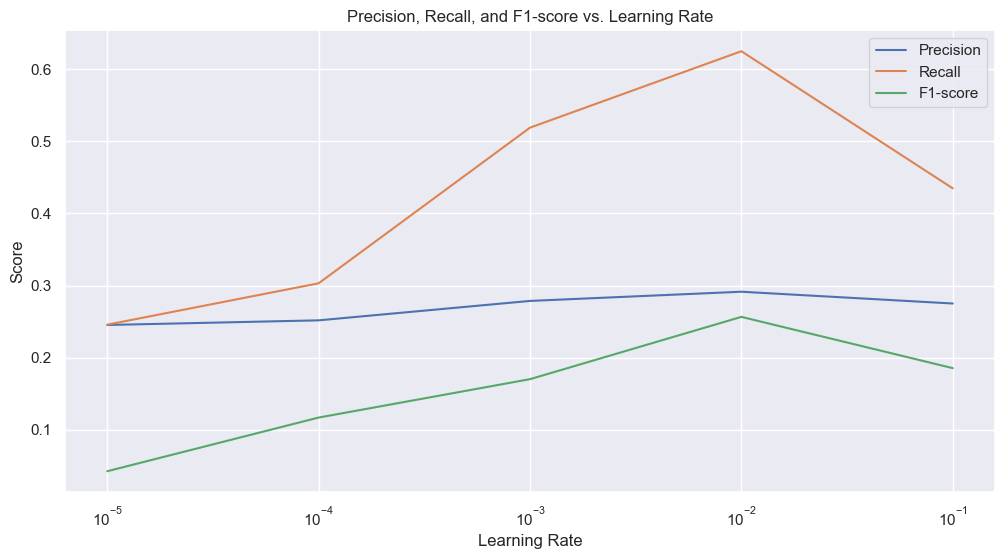

In [81]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()

def plot():
    if mean_cv_precision_scores == {} or mean_cv_recall_scores == {} or mean_cv_f1_scores == {}:
        print("Please delete the database and run the objective function again to get the scores.")
        return
    # Assuming you have already optimized the study and have obtained the mean cross-validation scores
    # for precision, recall, and F1-score for each learning rate
    learning_rates = [1e-1, 1e-2,1e-3, 1e-4, 1e-5]
    # Extract the scores from the dictionaries in the order of the learning rates
    precision_scores_plt = [mean_cv_precision_scores[lr] for lr in learning_rates]
    recall_scores_plt = [mean_cv_recall_scores[lr] for lr in learning_rates]
    f1_scores_plt = [mean_cv_f1_scores[lr] for lr in learning_rates]

    # Create a figure with a single subplot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the precision scores
    ax.plot(learning_rates, precision_scores_plt, label="Precision")

    # Plot the recall scores
    ax.plot(learning_rates, recall_scores_plt, label="Recall")

    # Plot the F1 scores
    ax.plot(learning_rates, f1_scores_plt, label="F1-score")

    # Set the axis labels and title
    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Score")
    ax.set_xscale("log")
    ax.set_title("Precision, Recall, and F1-score vs. Learning Rate")

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

plot()